# Gaussian Mixture Model (Olive Oils dataset)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.7


## Import local utility functions and classes

In [2]:
import sys
sys.path.append('../utils')
import utils as utl
from data import Data

## Model configuration

In [3]:
# model mode
model_mode      = 'sampling'
#model_mode      = 'training'

# data filenames
data_filename   = '../../data/olive_oils/FTIR_olive_oils.csv'
trace_filename  = './traces/trace_olive_oils'

## Load dataset, import and plot samples

In [4]:
# init dataset object
data_obj = Data(data_filename, 'label', -3)   
data_obj.data.head(5)
data = data_obj.data
data.head(5)

,798.892,800.8215,802.751,804.6805,806.61,808.5395,810.469,812.3985,814.328,816.2575,...,1885.2305,1887.16,1889.0895,1891.019,1892.9485,1894.878,1896.8085,code,label,sample
44,0.127147,0.127587,0.129321,0.131166,0.133155,0.135617,0.138395,0.140899,0.143519,0.145796,...,0.003791,0.003540,0.003430,0.003345,0.003275,0.003094,0.002959,2,Italy,23
47,0.126618,0.127110,0.128289,0.130156,0.132573,0.135221,0.137872,0.140590,0.142919,0.144947,...,0.006713,0.006519,0.006012,0.005937,0.005862,0.005570,0.005606,2,Italy,24
4,0.128602,0.128790,0.130022,0.132012,0.134427,0.137070,0.139646,0.142338,0.144923,0.146958,...,0.010594,0.010379,0.010287,0.010127,0.009966,0.009760,0.009649,1,Greece,3
55,0.128149,0.128600,0.130136,0.132407,0.135488,0.138501,0.141224,0.144109,0.146412,0.148171,...,0.010286,0.010086,0.009620,0.009541,0.009713,0.009405,0.009267,3,Portugal,28
26,0.128867,0.129291,0.130672,0.132708,0.135109,0.137758,0.140860,0.143611,0.145792,0.147613,...,0.007027,0.006848,0.006511,0.006470,0.006405,0.006071,0.005872,2,Italy,14


Greece: blue
Italy: red
Portugal: green
Spain: orange


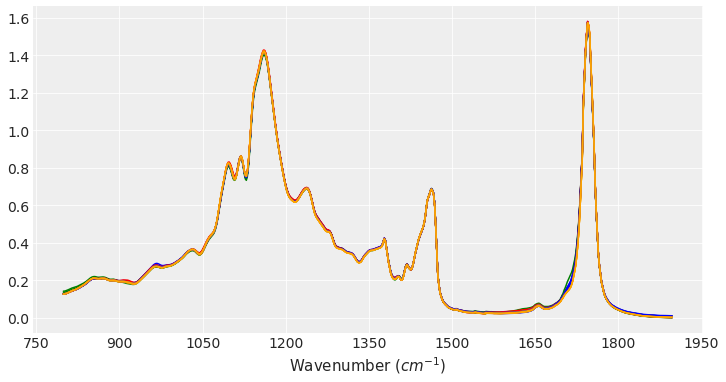

In [5]:
# list of class labels
class_labels = data_obj.get_class_labels()

# plot dataframe
utl.plot_data(data_obj, 20)

In [6]:
# number of samples from each class
print(data_obj.data[data_obj.label_column].value_counts())

Spain       50
Italy       34
Greece      20
Portugal    16
Name: label, dtype: int64


In [7]:
# generate training and test sets
train_data, test_data = train_test_split(data_obj.data, train_size=0.25, random_state=42)

# rename the index
test_data.index = range(len(test_data))
train_data.index = range(len(train_data))

In [8]:
test_data.shape

(90, 573)

In [9]:
train_data.shape

(30, 573)

# Model definition
The following model is assumed:

\begin{equation}
\large A_{m} \sim \text{U} (0, max(Y)) \\
\large \mu_{m} \sim \mathcal{N}(\mu_{m}, 50) \\
\large \sigma_{m} \sim |\mathcal{N}(0, 100)| \\
\large \epsilon \sim |\mathcal{N}(0, 1)| \\
\large \theta = \sum\limits_{m=1}^M [A_m \cdot e^{-\frac{(x_n-\mu_m)^2}{2\cdot\sigma_m^2}}] \\
\large y \sim \mathcal{N}(\theta, \epsilon)
\end{equation}

In [10]:
# 1D array of X values
x_val = np.array(train_data.columns[:data_obj.non_data_columns], dtype='float32')

# 2D array containing Y values (observation data)
x_n = train_data.columns[:data_obj.non_data_columns]
x_s = train_data[x_n].values

In [11]:
traces = []
models = []

# prior on peak positions (Lerma et al. 2010)
mu_p = [1096, 1118, 1161, 1237, 1377, 1465, 1654, 1711, 1744]
peaks = [len(mu_p)]

for npeaks in peaks:
    if model_mode == 'training':
        print("training model on " + str(npeaks) + " peaks")
        
    with pm.Model() as model:
        amp = pm.Uniform('amp', 0, x_s[0].max(), shape=(1,npeaks))
        #mu = pm.Normal('mu', mu=np.linspace(x_val.min(), x_val.max(), npeaks), sd=50, 
        #               shape=(1,npeaks), transform=pm.distributions.transforms.ordered)
        mu = pm.Normal('mu', mu=mu_p, sd=50, shape=(1,npeaks), transform=pm.distributions.transforms.ordered)
        sigma = pm.HalfNormal('sigma', sd=100, shape=(1,npeaks))
        epsilon = pm.HalfNormal('epsilon', sd=1)

        y = pm.Deterministic('y', (amp.T * np.exp(-(x_val - mu.T)**2/(2 * sigma.T**2))).sum(axis=0))

        y_pred = pm.Normal('y_pred', mu=y, sd=epsilon, observed=x_s)

        if model_mode == 'training':
            trace = pm.sample(2000, init='adapt_diag', random_seed=42)
            traces.append(trace)
            models.append(model)
        else:
            # load traces from trained model
            trace = pm.backends.text.load(trace_filename)
            traces.append(trace)
            models.append(model)
            break

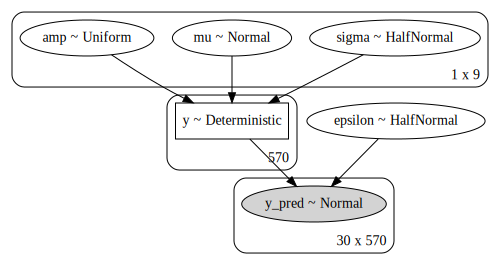

In [12]:
pm.model_to_graphviz(model)

# Model evaluation

In [13]:
#varnames = ['amp', 'mu', 'sigma', 'epsilon']
#coef = az.summary(traces[1], varnames)
#coef

In [14]:
#az.plot_trace(traces[0], varnames, combined=True);
#az.plot_trace(traces[1], varnames);

In [15]:
ppc_mm = [pm.sample_posterior_predictive(traces[i], samples=500, model=models[i]) for i in range(len(peaks))]

100%|██████████| 500/500 [00:08<00:00, 57.11it/s]


In [16]:
#data_ppc = az.from_pymc3(trace=trace, posterior_predictive=ppc)
#ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

## Compare distribution of data and posterior samples

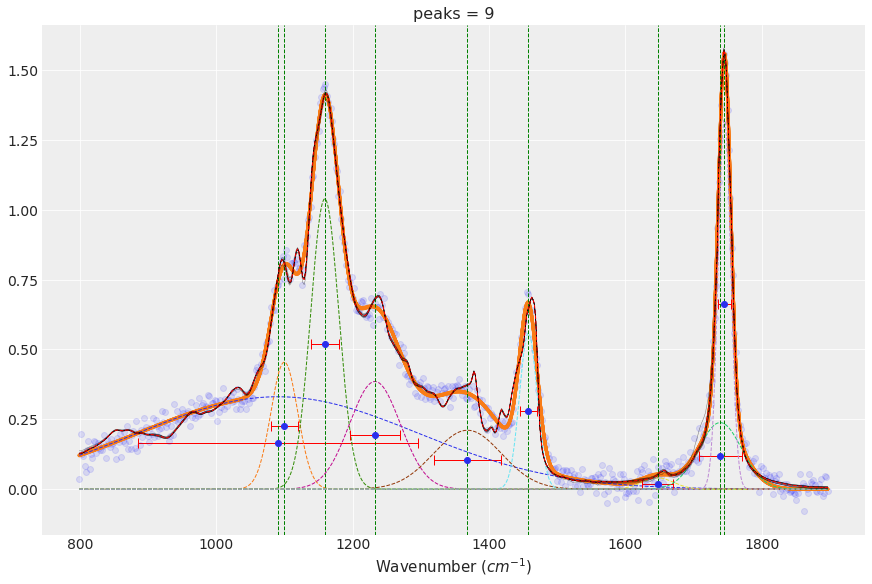

In [17]:
_, ax = plt.subplots(1, 1, figsize=(12, 8), constrained_layout=True)
ax = np.ravel(ax)
for idx, ppc_x in enumerate(ppc_mm):
    # plot samples from the posterior
    sp = ppc_x['y_pred']
    for i in range(1):
        ax[idx].plot(x_val, sp[i,0,:], 'o', color="blue", linewidth=1, alpha=.1)
    
    # plot samples from the posterior model formula
    for i in range(20):
        ax[idx].plot(x_val, traces[idx]['y'][i], color='C1', alpha=.5, linewidth=3);
    
    # plot mixture components 
    A = traces[idx]['amp'].mean(axis=0).flatten()
    M = traces[idx]['mu'].mean(axis=0).flatten()
    S = traces[idx]['sigma'].mean(axis=0).flatten()
    for j in range(len(A)):
        Y = A[j] * np.exp(-(x_val - M[j])**2/(2 * S[j]**2))
        ax[idx].plot(x_val, Y, '--', linewidth=1)
        ax[idx].axvline(M[j], linestyle='--', linewidth=1, color='g')
        ax[idx].errorbar(x=M[j], y=.5*A[j], xerr=S[j], fmt='o', 
                         ecolor='r', elinewidth=1, capsize=5, capthick=1)
        
    # plot samples from the dataset
    for i in range(10):
        y_val = train_data.values[i]
        ax[idx].plot(x_val, y_val[:data_obj.non_data_columns], '-', color="black", alpha=.5, linewidth=.5)
        
    # plot the mean of the real data
    ax[idx].set(xlabel='Wavenumber ($cm^{-1}$)')
    ax[idx].plot(x_val, data_obj.data.iloc[:,:data_obj.non_data_columns].mean(), '--', color='red', linewidth=1);
    ax[idx].set_title('peaks = {}'.format(peaks[idx]))

In [18]:
if len(models)>1:
    comp = az.compare(dict(zip(peaks, traces)), method='BB-pseudo-BMA')
    print(comp)

In [19]:
if len(models)>1:
    az.plot_compare(comp);

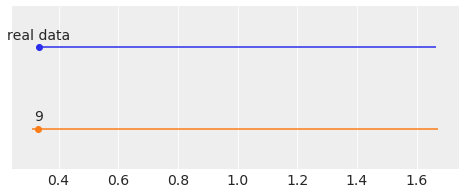

In [20]:
plt.figure(figsize=(8, 3))
data = [x_s]
dd = [ppc_mm[i]['y_pred'] for i in range(len(ppc_mm))]
data.extend(dd)
labels = ['real data']
pk = [str(peaks[i]) for i in range(len(peaks))]
labels.extend(pk)
for i, d in enumerate(data):
    mean = d.mean()
    err = np.percentile(d, [2.5, 97.5])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.1, labels[i], ha='center', fontsize=14)
plt.ylim([-i-0.5, 0.5])
plt.yticks([]);

In [21]:
if len(models)>1:
    for idx, trace in enumerate(traces):
        print(str(peaks[idx]) + " peaks, bfmi: " + str(az.bfmi(trace)))

In [22]:
for idx, ppc in enumerate(ppc_mm):
    print("--- " + str(peaks[idx]) + " peaks -----------\n" + str(az.r2_score(x_s, ppc['y_pred'])))

--- 9 peaks -----------
r2        0.992054
r2_std    0.000503
dtype: float64


In [23]:
varnames = ['amp', 'mu', 'sigma', 'epsilon']
for idx, trace in enumerate(traces):
    print("\n--- " + str(peaks[idx]) + " peaks ----------------------------------")
    coef = az.summary(trace, varnames)
    print(coef)


--- 9 peaks ----------------------------------
                mean     sd    hpd_3%   hpd_97%  mcse_mean  mcse_sd  ess_mean  \
amp[0,0]       0.331  0.001     0.328     0.333      0.000    0.000    3509.0   
amp[0,1]       0.455  0.002     0.451     0.459      0.000    0.000    4254.0   
amp[0,2]       1.040  0.003     1.033     1.046      0.000    0.000    1716.0   
amp[0,3]       0.385  0.002     0.381     0.389      0.000    0.000    3293.0   
amp[0,4]       0.211  0.002     0.207     0.215      0.000    0.000    3461.0   
amp[0,5]       0.559  0.002     0.555     0.563      0.000    0.000    4213.0   
amp[0,6]       0.041  0.002     0.038     0.044      0.000    0.000    3227.0   
amp[0,7]       0.238  0.005     0.230     0.247      0.000    0.000    1506.0   
amp[0,8]       1.328  0.005     1.319     1.336      0.000    0.000    1662.0   
mu[0,0]     1090.240  1.131  1088.093  1092.265      0.020    0.014    3055.0   
mu[0,1]     1099.698  0.146  1099.421  1099.965      0.003   


--- 9 peaks ----------------------------------


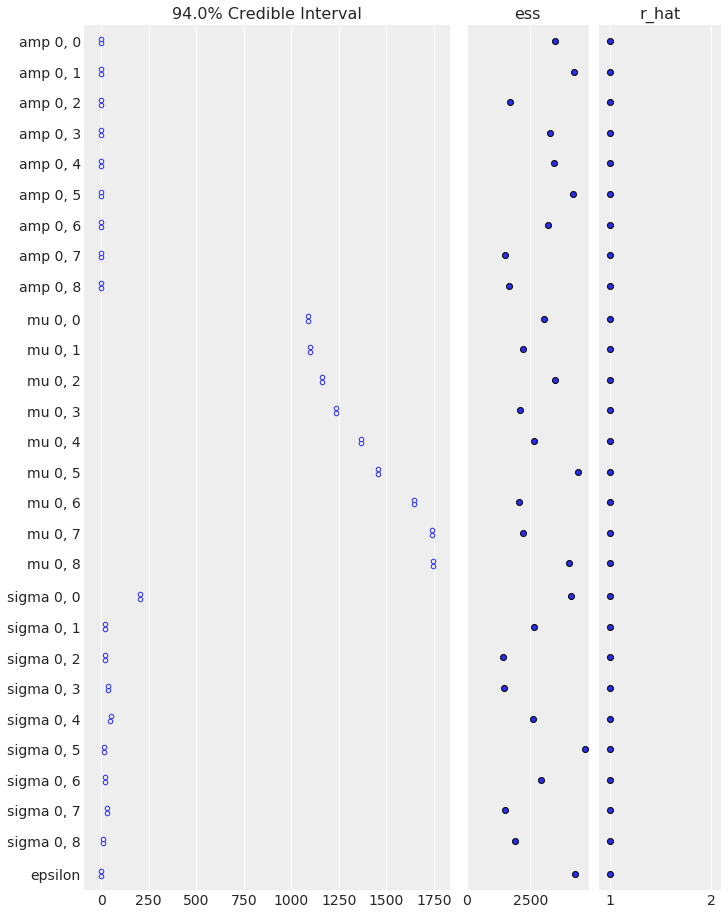

In [24]:
for idx, trace in enumerate(traces):
    print("\n--- " + str(peaks[idx]) + " peaks ----------------------------------")
    az.plot_forest(trace, var_names = ['amp', 'mu', 'sigma', 'epsilon'], r_hat=True, ess=True);

## Save results

In [25]:
if model_mode == 'training':
    # save inference results
    pm.backends.text.dump(trace_filename, traces[0])